### Import Package

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,MaxPooling2D, Conv2D, Flatten, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from google.colab import files
import shutil
import os

### Import Data

In [3]:
!pip install -U -q kaggle
!mkdir  /root/.kaggle

files.upload()
!cp kaggle.json /root/.kaggle
!kaggle datasets download -d crawford/emnist

Saving kaggle.json to kaggle.json
100% 1.24G/1.24G [01:07<00:00, 15.7MB/s]



In [4]:
!apt install pv
!unzip -o /content/emnist.zip | pv -l >/dev/null
os.remove('emnist.zip')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  doc-base
The following NEW packages will be installed:
  pv
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 48.3 kB of archives.
After this operation, 123 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 pv amd64 1.6.6-1 [48.3 kB]
Fetched 48.3 kB in 1s (41.2 kB/s)
Selecting previously unselected package pv.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
43.0  0:01:21 [ 525m/s] [                    <=>                               ]


In [5]:
# Import Data
train_data_path = '/content/emnist-balanced-train.csv'
test_data_path = '/content/emnist-balanced-test.csv'

In [6]:
train_data = pd.read_csv(train_data_path, header=None)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB


In [9]:
def show_img(data, row_num):
    img_flip = np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
    plt.title('Class: ' + str(data.values[row_num,0]) + ', Label: ' + str(class_mapping[data.values[row_num,0]]))
    plt.imshow(img_flip, cmap='Greys_r')

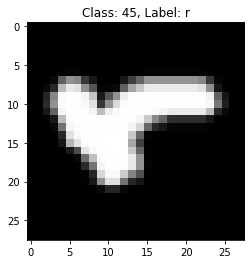

In [10]:
show_img(train_data, 0)

### Modelling

In [11]:
num_classes = 47 
img_size = 28

def img_label_load(data_path, num_classes=None):
    data = pd.read_csv(data_path, header=None)
    data_rows = len(data)
    if not num_classes:
        num_classes = len(data[0].unique())
    
    img_size = int(np.sqrt(len(data.iloc[0][1:])))
    imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3]) 
    labels = keras.utils.to_categorical(data.values[:,0], num_classes)
    return imgs/255., labels

In [13]:
model = keras.models.Sequential([
   Conv2D(filters=3, kernel_size=(3,3),activation='relu', input_shape=(img_size,img_size,1)),
   MaxPooling2D(),
   Conv2D(filters=9, kernel_size=(3,3),activation='relu', input_shape=(img_size,img_size,1)),
   MaxPooling2D(),
   Dropout(.5),
   Flatten(),
   Dense(units=150, activation='relu'),
   Dense(units=num_classes, activation='softmax')                              
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 3)         30        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 9)         252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 9)           0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 9)           0         
_________________________________________________________________
flatten (Flatten)            (None, 225)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               3

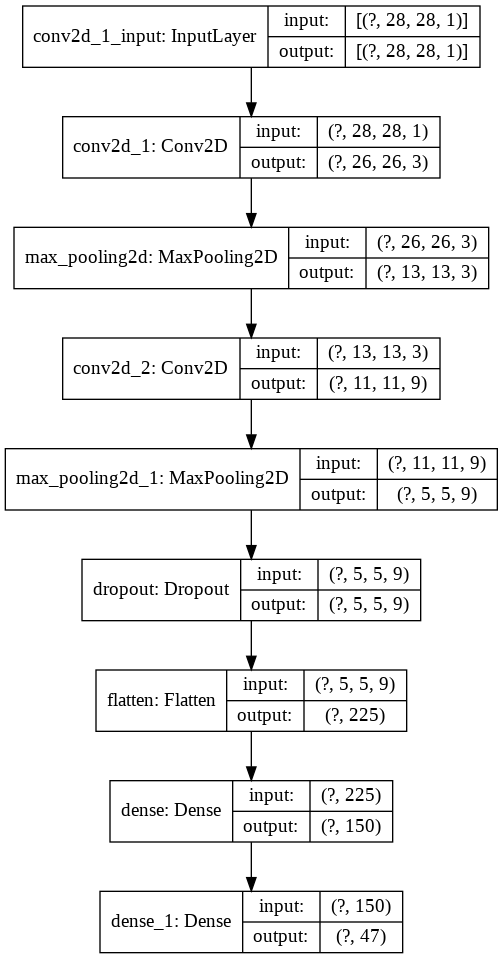

In [14]:
keras.utils.plot_model(model, "arsitektur_model.png", show_shapes=True)

In [15]:
X, y = img_label_load(train_data_path)

In [23]:
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.3,)
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.3,
                                            width_shift_range=.2, height_shift_range=.2,
                                            rotation_range=60, zoom_range=.2, shear_range=.3)

training_data_generator = data_generator.flow(X, y, subset='training',)
validation_data_generator = data_generator.flow(X, y, subset='validation')
history = model.fit_generator(training_data_generator,epochs=5, # can change epochs to 10
                              validation_data=validation_data_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
2468/2468 [==============================] - 40s 16ms/step - loss: 1.4840 - accuracy: 0.5655 - val_loss: 0.7333 - val_accuracy: 0.7728
Epoch 2/5
2468/2468 [==============================] - 39s 16ms/step - loss: 0.9450 - accuracy: 0.7011 - val_loss: 0.6054 - val_accuracy: 0.8015
Epoch 3/5
2468/2468 [==============================] - 39s 16ms/step - loss: 0.8355 - accuracy: 0.7295 - val_loss: 0.5573 - val_accuracy: 0.8141
Epoch 4/5
2468/2468 [==============================] - 40s 16ms/step - loss: 0.7775 - accuracy: 0.7447 - val_loss: 0.5272 - val_accuracy: 0.8267
Epoch 5/5
2468/2468 [==============================] - 40s 16ms/step - loss: 0.7405 - accuracy: 0.7552 - val_loss: 0.5020 - val_accuracy: 0.8285


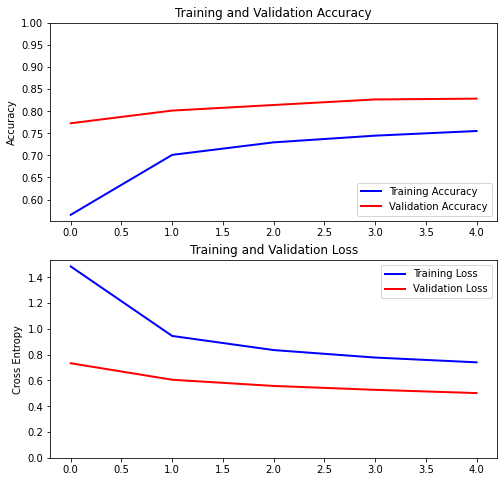

In [30]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy',color='b', linewidth= 2)
plt.plot(val_acc, label='Validation Accuracy',color='r', linewidth= 2)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss',color='b', linewidth= 2)
plt.plot(val_loss, label='Validation Loss',color='r', linewidth= 2)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Testing

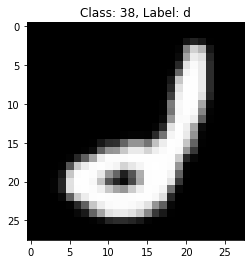

In [25]:
test_data = pd.read_csv(test_data_path, header=None)
show_img(test_data, 123)

In [26]:
X_test, y_test = img_label_load(test_data_path)

In [27]:
def run_prediction(idx):
    result = np.argmax(model.predict(X_test[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', class_mapping[result])
    print('Label: ', test_data.values[idx,0])
    show_img(test_data, idx)

Prediction:  29 , Char:  T
Label:  29


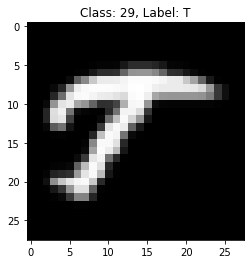

In [28]:
run_prediction(90)

Prediction:  9 , Char:  9
Label:  9
Prediction:  16 , Char:  G
Label:  16
Prediction:  29 , Char:  T
Label:  29
Prediction:  9 , Char:  9
Label:  16
Prediction:  14 , Char:  E
Label:  14
Prediction:  1 , Char:  1
Label:  1
Prediction:  9 , Char:  9
Label:  44
Prediction:  27 , Char:  R
Label:  27
Prediction:  26 , Char:  Q
Label:  26


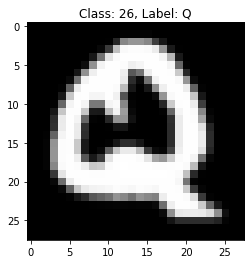

In [29]:
import random

for _ in range(1,10):
    idx = random.randint(0, 47-1)
    run_prediction(idx)

In [ ]:
model.save('model.h5')

In [50]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(28, 28),grayscale=True)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(fn)
  print(classes)

Saving train_61_00043.png to train_61_00043.png
train_61_00043.png
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [54]:
class_mapping[10]

'A'